In [2]:
!pip install matplotlib
!pip install pandas
!pip install openpyxl
!pip install seaborn
!pip install numpy
!pip install scikit-learn

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [5]:
df = pd.read_csv("./norm-z/SUS 5200 B1 PMU S SMDB E12 11 S.csv", index_col = 0, parse_dates = [0])

In [6]:
df.head()

,Y Phase SUS 5200 B1 PMU S SMDB E12 11 SA04 DB AVoltage (volt),Power Factor,Total Energy (kilowatt hour),Power (kilowatt),Y Phase Current (ampere),B Phase Current (ampere),R Phase Current (ampere),R Phase Voltage (volt),B Phase Voltage (volt),Frequency (hertz)
Date Time,,,,,,,,,,
2024-07-24 13:59:00,-1.608206e+00,-1.299224e+00,-1.005003,0.291144,0.163543,0.850096,0.554587,-1.694328,-1.622482,-3.360545e-01
2024-07-24 14:01:00,-1.506394e+00,2.744257e+00,-1.004856,1.057824,0.994190,0.944028,1.326377,0.000000,-1.514774,6.044700e-13
2024-07-24 14:04:00,-1.608206e+00,4.489166e-15,-1.004612,1.014014,0.955853,0.756164,1.264136,0.000000,-1.622482,6.044700e-13
2024-07-24 14:07:00,2.893645e-14,4.489166e-15,-1.004344,1.452117,0.917515,0.962814,2.309788,0.000000,-1.730190,6.044700e-13
2024-07-24 14:11:00,2.893645e-14,4.489166e-15,-1.004050,1.014014,1.160320,1.451258,2.508960,0.000000,-1.837898,6.044700e-13


In [7]:
# Drop Total Energy
df.drop("Total Energy (kilowatt hour)", axis = 1, inplace = True)

In [8]:
# Add temporal features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

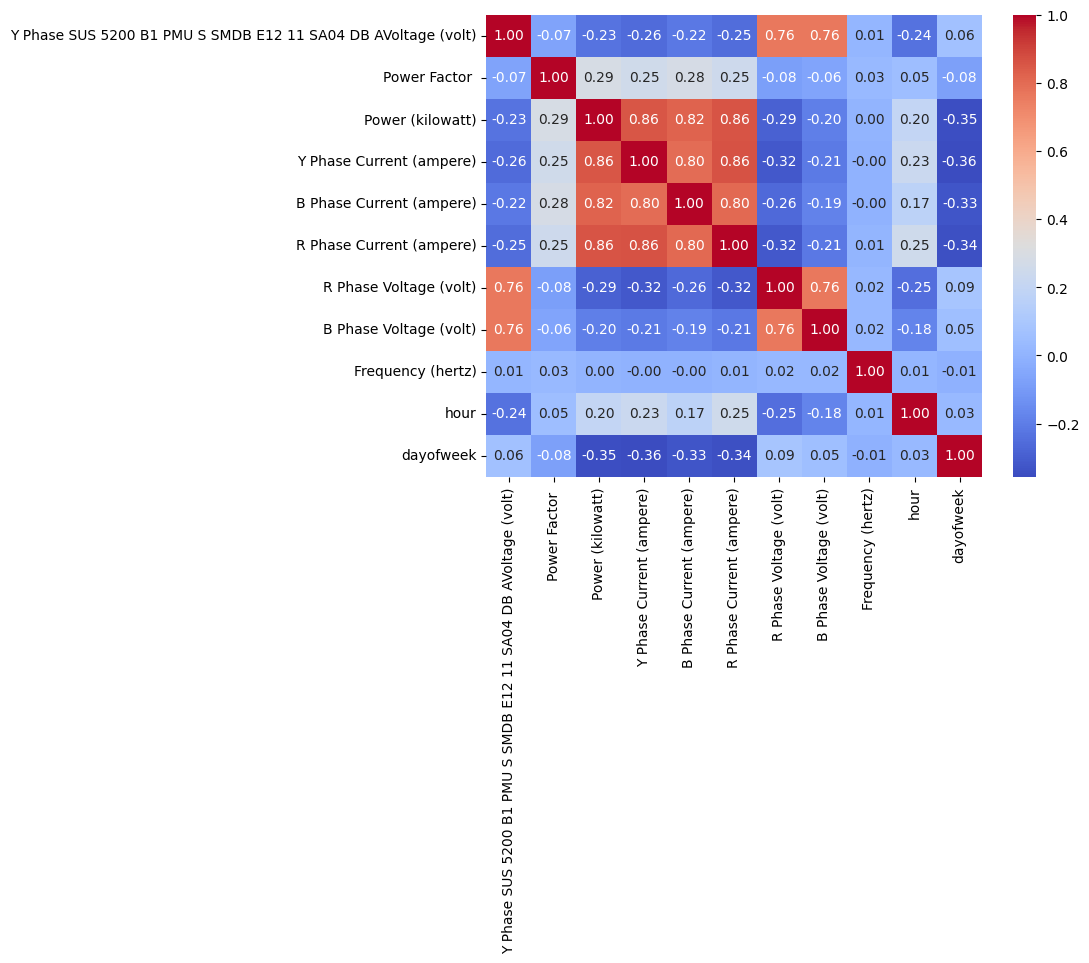

In [9]:
correlation_matrix = df.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

In [10]:
df.columns

Index(['Y Phase SUS 5200 B1 PMU S SMDB E12 11 SA04 DB AVoltage (volt)',
       'Power Factor ', 'Power (kilowatt)', 'Y Phase Current (ampere)',
       'B Phase Current (ampere)', 'R Phase Current (ampere)',
       'R Phase Voltage (volt)', 'B Phase Voltage (volt)', 'Frequency (hertz)',
       'hour', 'dayofweek'],
      dtype='object')

In [11]:
selected_columns = ['R Phase Voltage (volt)', 'Y Phase Current (ampere)']
new_df = df[selected_columns]
X = new_df

# 1. Isolation Forest

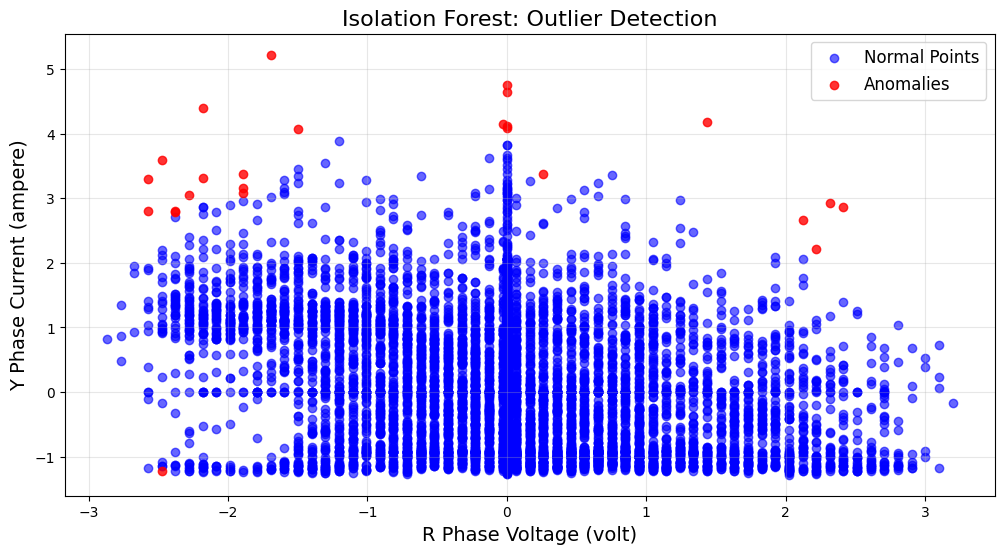

In [12]:
# Standardize the data, but skip now because the input data has been already normalized
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
X_scaled = X

# Fit Isolation Forest
# Here, contamination=0.0027 is the barrier of Y_Ampere=lowest singularities
iso_forest = IsolationForest(n_estimators=100, contamination=0.003, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X_scaled)

# Anomaly flag: -1 for anomalies, 1 for normal points
anomalies = df[df['Anomaly'] == -1]
normal = df[df['Anomaly'] == 1]

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(normal['R Phase Voltage (volt)'], normal['Y Phase Current (ampere)'],
            c='blue', label='Normal Points', alpha=0.6)
plt.scatter(anomalies['R Phase Voltage (volt)'], anomalies['Y Phase Current (ampere)'],
            c='red', label='Anomalies', alpha=0.8)
plt.title('Isolation Forest: Outlier Detection', fontsize=16)
plt.xlabel('R Phase Voltage (volt)', fontsize=14)
plt.ylabel('Y Phase Current (ampere)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 2. k-Means Clustering

### 2.1 Case k=3

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

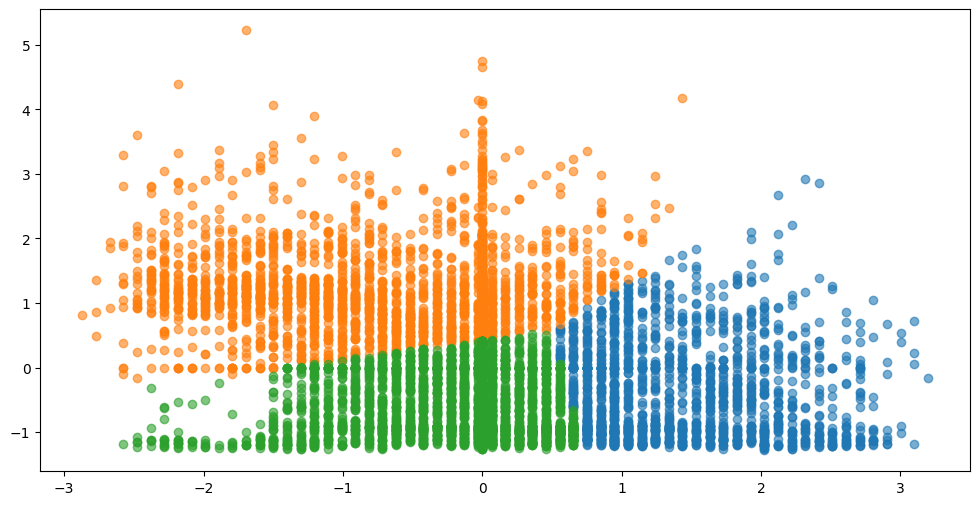

In [13]:
def k_means_cluster(k = 3):
    scaler = StandardScaler()
    
    #k = 3  # Number of clusters (adjust based on your data)
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    for cluster in range(k):
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data['R Phase Voltage (volt)'], cluster_data['Y Phase Current (ampere)'],
                    label=f'Cluster {cluster}', alpha=0.6)
    
    # Plot cluster centroids
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert centroids back to original scale
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
    
    plt.title('K-Means Clustering of Voltage and Current', fontsize=16)
    plt.xlabel('R Phase Voltage (volt)', fontsize=14)
    plt.ylabel('Y Phase Current (ampere)', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

k_means_cluster(3)

### 2.2 k Optimization by Elbow/Silhouette Scores

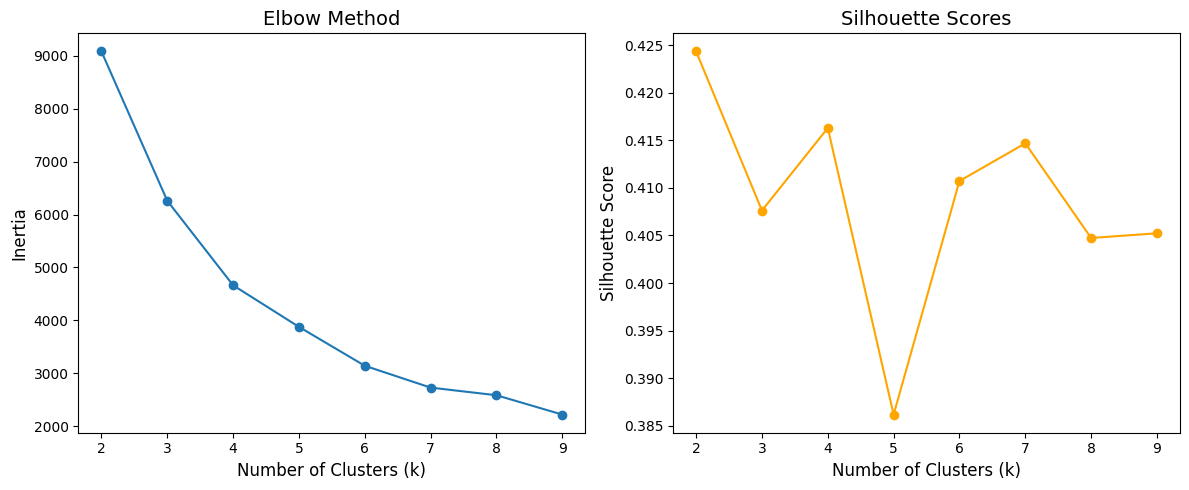

In [14]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
for k in range(2, 10):  # Try cluster numbers from 2 to 9
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest centroid
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Inertia and Silhouette Scores
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

plt.tight_layout()
plt.show()

### 2.3 Case k=2

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

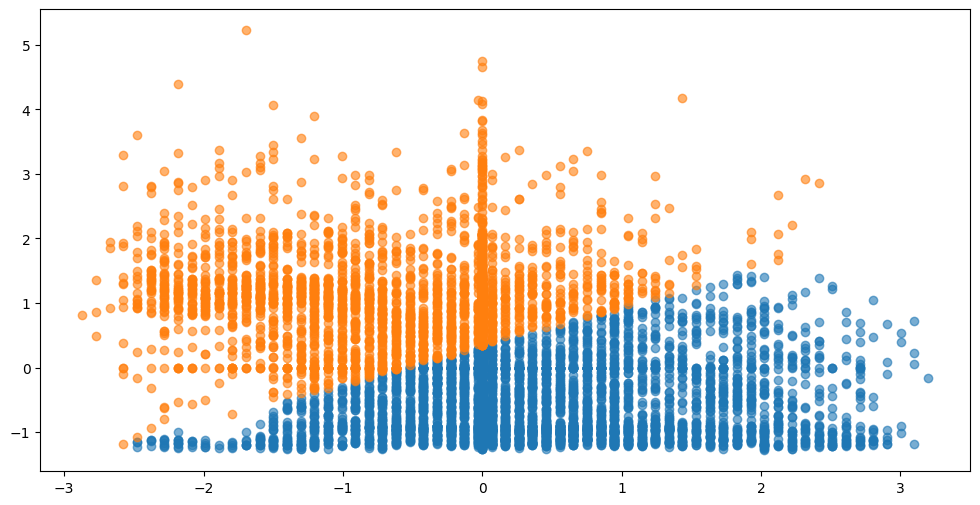

In [15]:
k_means_cluster(2)

# 3. Hierarchical Clustering

### 3.1 Linkage Method = "ward"

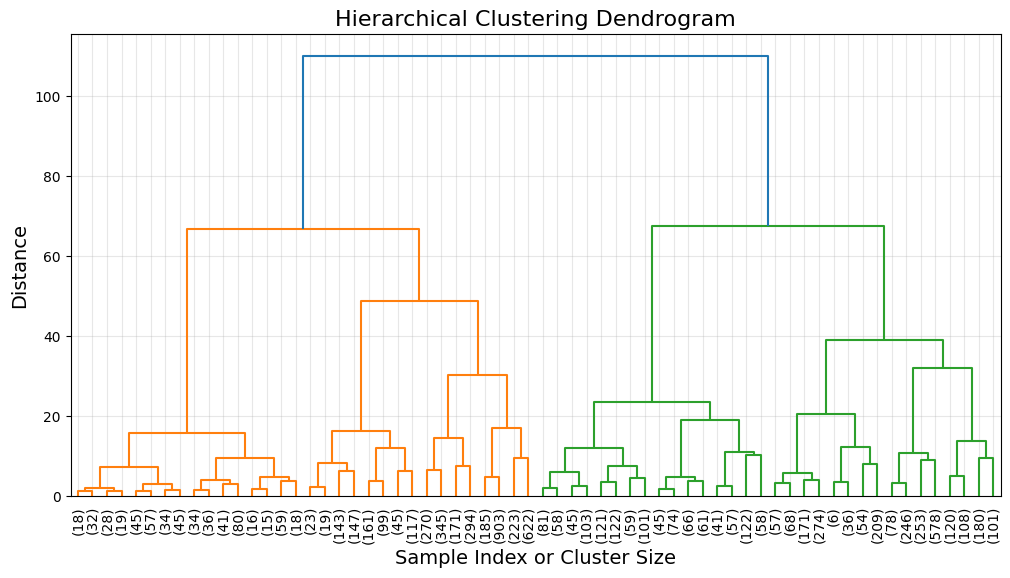

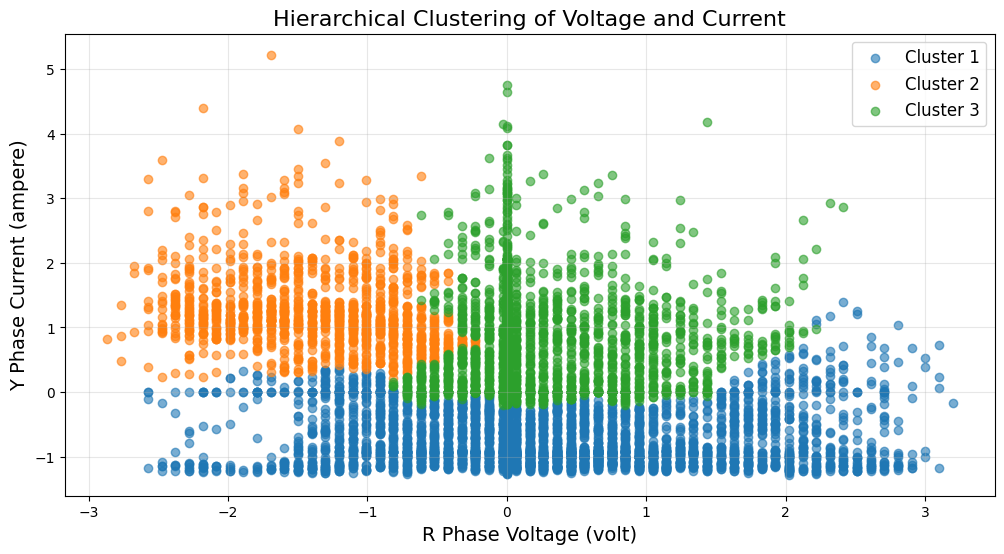

In [16]:
def hierarchical_cluster(linkage_method):   # Use 'ward', 'single', or 'complete'
    linkage_matrix = linkage(X_scaled, method=linkage_method)
    
    # Plot the dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
    plt.xlabel('Sample Index or Cluster Size', fontsize=14)
    plt.ylabel('Distance', fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()
    
    # Decide the number of clusters (adjust 't' based on dendrogram)
    num_clusters = 3  # Change this based on your analysis
    df['Cluster'] = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    
    # Visualization of clusters
    plt.figure(figsize=(12, 6))
    for cluster in range(1, num_clusters + 1):
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data['R Phase Voltage (volt)'], cluster_data['Y Phase Current (ampere)'],
                    label=f'Cluster {cluster}', alpha=0.6)
    
    plt.title('Hierarchical Clustering of Voltage and Current', fontsize=16)
    plt.xlabel('R Phase Voltage (volt)', fontsize=14)
    plt.ylabel('Y Phase Current (ampere)', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

hierarchical_cluster("ward")

### 3.2 Linkage Method = "single"

In [ ]:
hierarchical_cluster("single")

### 3.3 Linkage Method = "complete"

In [ ]:
hierarchical_cluster("complete")

# 4. DBSCAN Clustering

### 4.1 eps=0.5

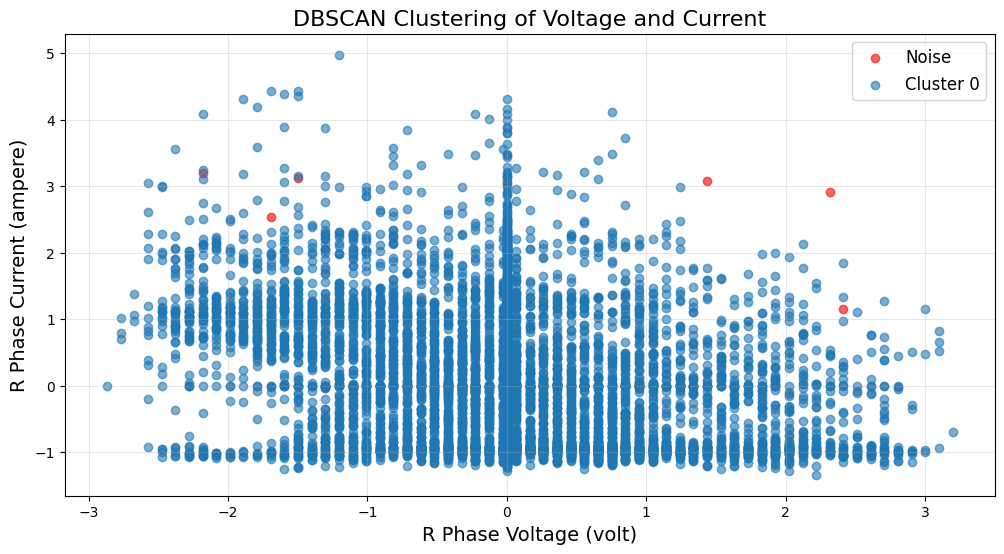

In [19]:
def dbscan_cluster(eps): # Maximum distance for two points to be considered neighbors
    min_samples = 5  # Minimum number of points to form a cluster
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['Cluster'] = dbscan.fit_predict(X_scaled)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    # Plot each cluster
    unique_clusters = np.unique(df['Cluster'])
    for cluster in unique_clusters:
        cluster_data = df[df['Cluster'] == cluster]
        if cluster == -1:
            # Noise points (outliers)
            plt.scatter(cluster_data['R Phase Voltage (volt)'], cluster_data['R Phase Current (ampere)'], 
                        label='Noise', color='red', alpha=0.6)
        else:
            # Regular clusters
            plt.scatter(cluster_data['R Phase Voltage (volt)'], cluster_data['R Phase Current (ampere)'], 
                        label=f'Cluster {cluster}', alpha=0.6)
    
    plt.title('DBSCAN Clustering of Voltage and Current', fontsize=16)
    plt.xlabel('R Phase Voltage (volt)', fontsize=14)
    plt.ylabel('R Phase Current (ampere)', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

dbscan_cluster(0.5)

### 4.2 Eps Optimization

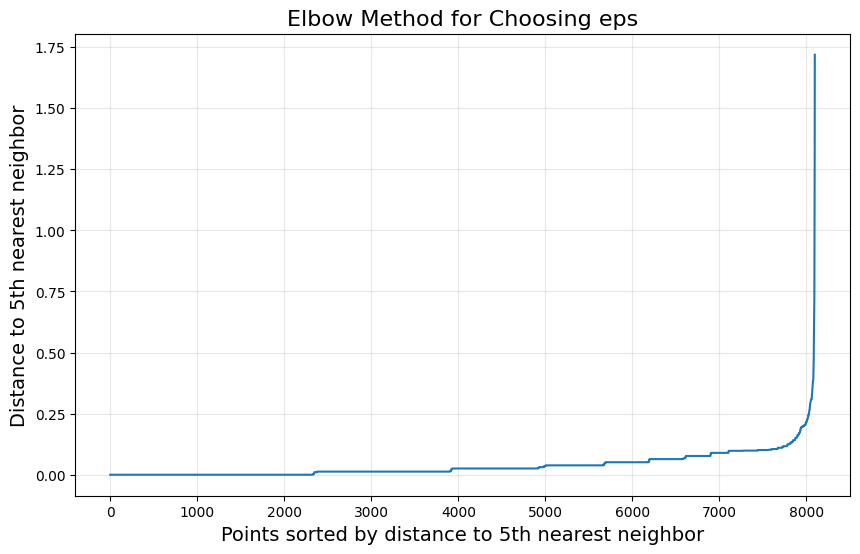

In [18]:
nearest_neighbors = NearestNeighbors(n_neighbors=5)  # n_neighbors = min_samples
nearest_neighbors.fit(X_scaled)
distances, _ = nearest_neighbors.kneighbors(X_scaled)

# Sort and plot distances
distances = np.sort(distances[:, -1])  # Sort by the kth nearest neighbor distance
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Elbow Method for Choosing eps', fontsize=16)
plt.xlabel('Points sorted by distance to 5th nearest neighbor', fontsize=14)
plt.ylabel('Distance to 5th nearest neighbor', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

### 4.3 eps=0.25

In [ ]:
dbscan_cluster(0.25)